In [16]:
# I want to train a CNN using the TuSimple training data that I got from Kaggle. 
# Now I need to train a CNN... I preferrably want to use an already existing CNN strucutre to save time.
# U-Net

# I will first explore the TuSimple training data first, before jumping into training a CNN.
# Therefore, lets do some Exploratory Data Analysis on the TuSimple Dataset. 


# If the x-value is -2, then there is no lane.
# When the x-value is a valid number (>= 0), it means that the lane is present a that y-coordinate. 

In [18]:
import os
import json
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from pprint import pprint
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import time

In [20]:
def find_annotation_file(filename, search_path):
    import os
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            return os.path.join(root, filename)
    return None

In [22]:
# Set and normalize the dataset path
dataset_path = r'C:\Users\caleb\Ai_Project\Training\TUSimple\train_set'
print(f"Dataset path: {dataset_path}")

# Construct and normalize the annotation file path
annotation_file = os.path.join(dataset_path, 'label_data_0531.json')
annotation_file = os.path.normpath(annotation_file)
print(f"Annotation file path: {annotation_file}")

# Verify the annotation file exists
if os.path.isfile(annotation_file):
    print("Annotation file found. Proceeding to load annotations.")
    with open(annotation_file, 'r') as f:
        annotations = [json.loads(line) for line in f]
    print(f"Total annotations loaded: {len(annotations)}")
else:
    print(f"Annotation file not found at: {annotation_file}")
    # Search for the file in subdirectories
    annotation_file = find_annotation_file('label_data_0601.json', dataset_path)
    if annotation_file:
        print(f"Annotation file found at: {annotation_file}")
        with open(annotation_file, 'r') as f:
            annotations = [json.loads(line) for line in f]
        print(f"Total annotations loaded: {len(annotations)}")
    else:
        print("Annotation file still not found. Please verify the dataset structure.")

Dataset path: C:\Users\caleb\Ai_Project\Training\TUSimple\train_set
Annotation file path: C:\Users\caleb\Ai_Project\Training\TUSimple\train_set\label_data_0531.json
Annotation file found. Proceeding to load annotations.
Total annotations loaded: 358


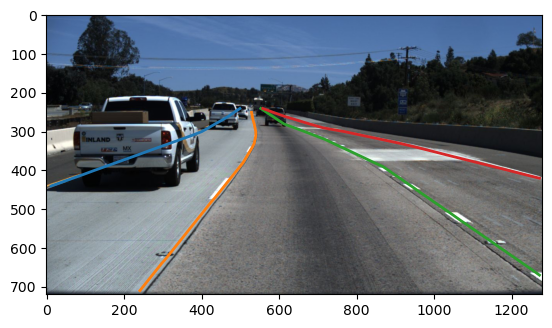

In [24]:
def plot_lanes(image_path, lanes, h_samples):
    img = mpimg.imread(os.path.join(dataset_path, image_path))
    plt.imshow(img)
    for lane in lanes:
        x_coords = [x if x >= 0 else None for x in lane]
        plt.plot(x_coords, h_samples, linewidth=2)
    plt.show()

# Plot a sample image with annotations
sample_annotation = annotations[0]
plot_lanes(sample_annotation['raw_file'], sample_annotation['lanes'], sample_annotation['h_samples'])

In [25]:
# Find all JSON annotation files in the dataset directory
annotation_files = glob.glob(os.path.join(dataset_path, '*.json'))

annotations = []
for ann_file in annotation_files:
    print(f"Loading annotations from: {ann_file}")
    with open(ann_file, 'r') as f:
        annotations.extend([json.loads(line) for line in f])

print(f"Total annotations loaded: {len(annotations)}")

Loading annotations from: C:\Users\caleb\Ai_Project\Training\TUSimple\train_set\label_data_0313.json
Loading annotations from: C:\Users\caleb\Ai_Project\Training\TUSimple\train_set\label_data_0531.json
Loading annotations from: C:\Users\caleb\Ai_Project\Training\TUSimple\train_set\label_data_0601.json
Total annotations loaded: 3626


In [26]:
# 1. Data Preparation
# Convert annotations into a suitable format. 
# Generate training and validation datasets. 

# 2. Model Selection -> Choosing an appropriate CNN architecture
# ----> U-Net CNN Architecture

# 3. Model Training
# Define a loss funciton and optimizers
# Train the model 

# 4. Model Evaluation
# Taking the trained CNN model on the road for real-time testing. 

In [27]:
# 1. Data Preparation approach ! 
# I want to apply a masking technique to convert the annotations into a suitable and more understandable format. 
# Segmentation -> Classifying each pixel as part of a lane or not (0 or 1)
 

# SEGMENTATION
# First, I want to use mathematical imaging techniques to place a binary mask on overlayed onto the image.
# This will take all pixels that do not correspond with the background to be 0 and the lane pixels to be 1.

dataset_path = r'C:\Users\caleb\Ai_Project\Training\TUSimple\train_set'
mask_dir = os.path.join(dataset_path, 'masks')
os.makedirs(mask_dir, exist_ok=True)

def create_mask(annotation, img_shape):
    mask = np.zeros((img_shape[0], img_shape[1]), dtype=np.uint8)
    lanes = annotation['lanes']
    h_samples = annotation['h_samples']
    for lane in lanes:
        lane_points = []
        for x, y in zip(lane, h_samples):
            if x >= 0:
                lane_points.append((int(x), int(y)))
        if len(lane_points) > 1:
            cv2.polylines(mask, [np.array(lane_points)], isClosed=False, color=1, thickness=5)
    return mask

In [29]:
# Note that all 3626 binary masks were saved as png images into a folder called masks in the train_set folder. 

# Uncomment these lines if you want to re-generate the binary masks. 


#print("Generating masks...")
#for ann in tqdm(annotations):
    #image_path = os.path.join(dataset_path, ann['raw_file'])
    #if not os.path.isfile(image_path):
        #continue  # Skip if image doesn't exist
    #img = cv2.imread(image_path)
    #if img is None:
        #continue  # Skip if image cannot be read
    #mask = create_mask(ann, img.shape)
    #mask_filename = os.path.splitext(ann['raw_file'].replace('/', '_'))[0] + '_mask.png'
    #mask_path = os.path.join(mask_dir, mask_filename)
    #cv2.imwrite(mask_path, mask * 255)

In [33]:
# The next step is to split / generate the binary mask images into training and validation datasets.
image_paths = []
mask_paths = []

# First, I want to map the original image paths to the binary mask image paths. 

for ann in annotations:
    image_path = os.path.join(dataset_path, ann['raw_file'])
    mask_filename = os.path.splitext(ann['raw_file'].replace('/', '_'))[0] + '_mask.png'
    mask_path = os.path.join(mask_dir, mask_filename)
    if os.path.isfile(image_path) and os.path.isfile(mask_path):
        image_paths.append(image_path)
        mask_paths.append(mask_path)
        
# Split the data into training images , then masks and into validation images and masks. 
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)


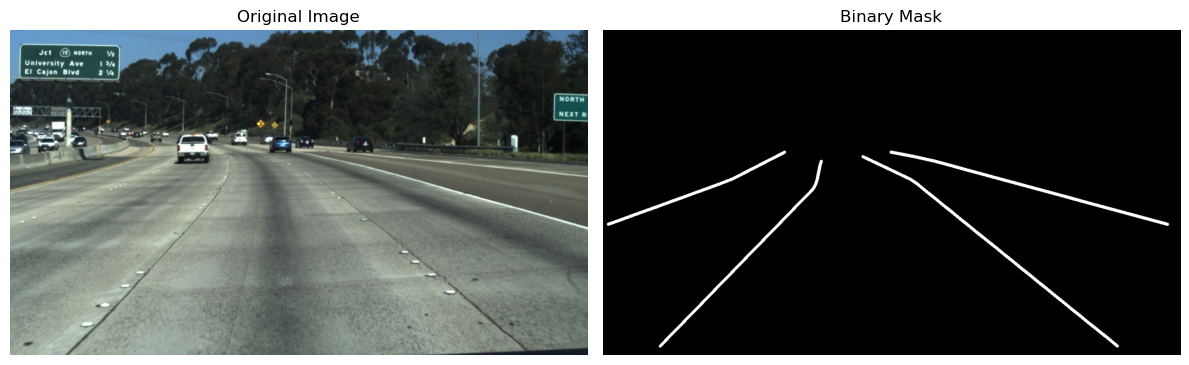

In [34]:
# Now I want to print the original image and its corresponding binary mask to show that is happening. 

image_path = train_images[0]
mask_path = train_masks[0]

# Read the image using OpenCV
image = cv2.imread(image_path)
# Convert BGR (OpenCV default) to RGB (matplotlib expects RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the mask as a grayscale image
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')  # Hide the axis

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

# Show the figure
plt.tight_layout()
plt.show()

In [36]:
IMG_HEIGHT = 256
IMG_WIDTH = 512
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE
SUBSET_SIZE = 3626

def load_data(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.round(mask)

    return image, mask

def create_dataset(image_paths, mask_paths):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_data, num_parallel_calls=AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def prepare_data(dataset_path, mask_dir, subset_size):
    image_paths = []
    mask_paths = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                mask_filename = os.path.splitext(file)[0] + '_mask.png'
                mask_path = os.path.join(mask_dir, mask_filename)
                if os.path.isfile(mask_path):
                    image_paths.append(image_path)
                    mask_paths.append(mask_path)
    
    # Randomly select a subset
    if len(image_paths) > subset_size:
        subset_indices = random.sample(range(len(image_paths)), subset_size)
        image_paths = [image_paths[i] for i in subset_indices]
        mask_paths = [mask_paths[i] for i in subset_indices]
    
    return train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

train_dataset = create_dataset(train_images, train_masks)
val_dataset = create_dataset(val_images, val_masks)

In [37]:
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = tf.keras.layers.Input(input_size)
    
    # Encoder
    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bridge
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    
    # Decoder
    up4 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = tf.keras.layers.concatenate([up4, conv2])
    conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up4)
    
    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.concatenate([up5, conv1])
    conv5 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(up5)
    
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv5)
    
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 256,  │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 256,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 512,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 512,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 96)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 512,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 512,  │         33 │ conv2d_4[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,617 (904.75 KB)

 Trainable params: 231,617 (904.75 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
EPOCHS = 1

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1286s 4s/step - accuracy: 0.9655 - loss: 0.1340 - val_accuracy: 0.9834 - val_loss: 0.0619


In [41]:
model.save('big_model.keras')

In [9]:
# Now I want to test this trained CNN with an image to see if the model can detect the lanes
# Constants (make sure these match your training setup)
# Update constants to match your model's expected input
# Constants

model = load_model('my_model.keras')

IMG_HEIGHT = 256
IMG_WIDTH = 512

def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Ensure 3 channels (RGB)
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

    prediction = model.predict(image)
    return prediction[0, :, :, 0]

def display_results(original_image, predicted_mask):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Ensure white lanes on black background
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)
    ax2.imshow(binary_mask, cmap='gray')
    ax2.set_title('Predicted Mask')
    ax2.axis('off')
    
    # Overlay the mask on the original image
    overlay = original_image.copy()
    overlay[binary_mask == 1] = [255, 0, 0]  # Red color for detected lanes
    ax3.imshow(overlay)
    ax3.set_title('Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load and preprocess a single test image
test_image_path = 'test2.png'
processed_image = load_and_preprocess_image(test_image_path)
print("Test image loaded and preprocessed.")
print(f"Processed image shape: {processed_image.shape}")

# Make prediction using the existing model
predicted_mask = predict_mask(model, processed_image)
print("Prediction completed.")

# Display results
original_image = np.array(Image.open(test_image_path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT)))
display_results(original_image, predicted_mask)

C:\Users\caleb\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


FileNotFoundError: [Errno 2] No such file or directory: 'test2.png'

In [ ]:
# Load and preprocess a single test image
test_image_path = 'test.png'
processed_image = load_and_preprocess_image(test_image_path)
print("Test image loaded and preprocessed.")
print(f"Processed image shape: {processed_image.shape}")

# Make prediction using the existing model
predicted_mask = predict_mask(model, processed_image)
print("Prediction completed.")

# Display results
original_image = np.array(Image.open(test_image_path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT)))
display_results(original_image, predicted_mask)

In [ ]:
# Load and preprocess a single test image
test_image_path = 'test3.png'
processed_image = load_and_preprocess_image(test_image_path)
print("Test image loaded and preprocessed.")
print(f"Processed image shape: {processed_image.shape}")

# Make prediction using the existing model
predicted_mask = predict_mask(model, processed_image)
print("Prediction completed.")

# Display results
original_image = np.array(Image.open(test_image_path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT)))
display_results(original_image, predicted_mask)

In [ ]:
# Load and preprocess a single test image
test_image_path = 'test4.png'
processed_image = load_and_preprocess_image(test_image_path)
print("Test image loaded and preprocessed.")
print(f"Processed image shape: {processed_image.shape}")

# Make prediction using the existing model
predicted_mask = predict_mask(model, processed_image)
print("Prediction completed.")

# Display results
original_image = np.array(Image.open(test_image_path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT)))
display_results(original_image, predicted_mask)

In [11]:
# Real Time Testing 
# Constants (adjust these to match your model's input requirements)
IMG_HEIGHT = 256
IMG_WIDTH = 512

model = load_model('my_model.keras')

def preprocess_frame(frame):
    # Resize and normalize the frame
    frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
    frame = frame.astype(np.float32) / 255.0
    return np.expand_dims(frame, axis=0)

def postprocess_prediction(prediction, original_shape):
    # Convert prediction to a visible mask
    mask = prediction[0, :, :, 0]
    mask = (mask > 0.5).astype(np.uint8) * 255
    return cv2.resize(mask, (original_shape[1], original_shape[0]))

# Open the webcam (Use 1 for Cam Studio virtual webcam)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video capture device 1")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Can't receive frame (stream end?). Exiting ...")
        break

    original_shape = frame.shape[:2]

    # Preprocess the frame
    processed_frame = preprocess_frame(frame)

    # Make a prediction
    prediction = model.predict(processed_frame)

    # Postprocess the prediction
    lane_mask = postprocess_prediction(prediction, original_shape)

    # Create a color mask for visualization
    color_mask = np.zeros_like(frame)
    color_mask[lane_mask > 0] = [0, 0, 255]  # Red color for detected lanes

    # Overlay the lane mask on the original frame
    output = cv2.addWeighted(frame, 1, color_mask, 0.5, 0)

    # Display the original frame and the frame with detected lanes
    cv2.imshow('Original', frame)
    cv2.imshow('Lane Detection', output)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [44]:
# Load the trained model
model_path = 'my_model.keras'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

model = load_model(model_path)
print(f"Model input shape: {model.input_shape}")

# Open the video file
video_path = 'Testing/minimal_glare.mp4'
if not os.path.exists(video_path):
    raise FileNotFoundError(f"Video file not found: {video_path}")

video = cv2.VideoCapture(video_path)

if not video.isOpened():
    raise IOError("Error opening video file")

# Get video properties
fps = int(video.get(cv2.CAP_PROP_FPS))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Video properties: {fps} FPS, {width}x{height}")

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (width, height))

total_frames = 0
start_time = time.time()

while True:
    ret, frame = video.read()
    if not ret:
        print("End of video stream or error reading frame")
        break

    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Preprocess the frame
    processed_frame = cv2.resize(frame_rgb, (512, 256))  # Resize to match model input
    processed_frame = processed_frame / 255.0  # Normalize
    processed_frame = np.expand_dims(processed_frame, axis=0)

    # Predict using the model
    prediction = model.predict(processed_frame, verbose=0)[0]

    # Post-process the prediction
    lane_mask = (prediction > 0.5).astype(np.uint8) * 255

    # Color the lanes
    colored_lanes = cv2.applyColorMap(lane_mask, cv2.COLORMAP_JET)

    # Resize back to original size and overlay on the original frame
    colored_lanes = cv2.resize(colored_lanes, (width, height))
    result = cv2.addWeighted(frame, 0.7, colored_lanes, 0.3, 0)

    # Calculate and display FPS
    total_frames += 1
    elapsed_time = time.time() - start_time
    fps_current = total_frames / elapsed_time
    cv2.putText(result, f"FPS: {fps_current:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Lane Detection', result)

    # Write the frame to the output video
    out.write(result)

    # Print progress every 100 frames
    if total_frames % 100 == 0:
        print(f"Processed {total_frames} frames. Average FPS: {fps_current:.2f}")

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Control frame rate to match video FPS
    time.sleep(max(1./fps - (time.time() - start_time) % (1./fps), 0))

video.release()
out.release()
cv2.destroyAllWindows()

print(f"Video processing complete. Total frames: {total_frames}")
print(f"Average FPS: {total_frames / elapsed_time:.2f}")

Model input shape: (None, 256, 512, 3)
Video properties: 30 FPS, 1920x1080
Video processing complete. Total frames: 11
Average FPS: 1.69
